# Download the binary version of CIFAR10 dataset

In [1]:
# download the dataset
! wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

--2024-03-12 16:46:37--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  47.0MB/s    in 3.8s    

2024-03-12 16:46:41 (43.3 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]



In [2]:
# extract the data batches
!tar -xvf  /content/cifar-10-python.tar.gz

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [3]:
# import libraries
import tensorflow as tf
import tensorflow.keras as k
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from six.moves import cPickle as pickle
import os

# Extract the data from the raw dataset

In [4]:
# load a single batch of CIFAR10
def load_CIFAR_batch(filename):
    with open(filename, 'rb') as f:
        # load the content of the pickle file
        datadict = pickle.load(f, encoding='latin1')
        # get the data
        X = datadict['data']
        # get the labels
        Y = datadict['labels']
        # conver them into numpy arrays
        X = np.array(X)
        Y = np.array(Y)
        # return the data and labels arrays
        return X, Y

In [5]:
# load all the batches
def load_CIFAR10(path):
    # to store the data of all the batches
    xs = []
    # to store the labels of all the batches
    ys = []
    # iterate over the batches from 1 to 5
    for number in range(1,6):
        # get the path of the file
        file = os.path.join(path, 'data_batch_%d' % (number))
        # get the content of the batch
        X, Y = load_CIFAR_batch(file)
        # append the data and labels of each batch
        xs.append(X)
        ys.append(Y)
    # concatenate all the data of all batches
    Xtrain = np.concatenate(xs)
    # concatenate all the labels of all batches
    Ytrain = np.concatenate(ys)
    # load the test data and labels from the test batch
    Xtest, Ytest = load_CIFAR_batch(os.path.join(path, 'test_batch'))
    # return
    return Xtrain, Ytrain, Xtest, Ytest

In [6]:
def get_CIFAR10_data():
    # get the train and test data and labels from the raw dataset
    X_train, y_train, X_test, y_test = load_CIFAR10('/content/cifar-10-batches-py')
    # convert the train data into float32
    x_train = X_train.astype('float32')
    # convert the test data into float32
    x_test = X_test.astype('float32')
    # normalize the train and test data
    x_train /= 255
    x_test /= 255
    # return
    return x_train, y_train, x_test, y_test

In [7]:
# extract the data
x_train, y_train, x_test, y_test = get_CIFAR10_data()

In [8]:
print('Train data shape  : ', x_train.shape)
print('Train labels shape: ', y_train.shape)
print('Test data shape   : ', x_test.shape)
print('Test labels shape : ', y_test.shape)

Train data shape  :  (50000, 3072)
Train labels shape:  (50000,)
Test data shape   :  (10000, 3072)
Test labels shape :  (10000,)


In [9]:
print('The training data contains %d images and %d labels' %(x_train.shape[0], y_train.shape[0]))
print('The testing  data contains %d images and %d labels' %(x_test.shape[0], y_test.shape[0]))

The training data contains 50000 images and 50000 labels
The testing  data contains 10000 images and 10000 labels


In [10]:
# define a function to rotate the images
def rotate(imgs):
    for i in range(imgs.shape[0]):
        imgs[i] = np.rot90(imgs[i], k=-1)
    return imgs

In [11]:
# define a function to reshape the each row of the training data set into an image
# of size 32, 32, 3
# since this is the binary version of the data, we also need to swap the axes
# and finally all the iamges need to be rotated
def convert_into_images(data):
    data_shaped = data.reshape(data.shape[0], 3, 32, 32)
    data_swaped = np.swapaxes(data_shaped, 1, 3)
    data_rot = rotate(data_swaped)
    return data_rot

In [12]:
# restore the training and testing images
x_train = convert_into_images(x_train)
x_test = convert_into_images(x_test)

In [13]:
# to make sure that the training and testing data have the proper shape
print('the training data has %d images of the shape : (%d, %d, %d)' % (x_train.shape[0], x_train.shape[1], x_train.shape[2], x_train.shape[3]))
print('the testing  data has %d images of the shape : (%d, %d, %d)' % (x_test.shape[0], x_test.shape[1], x_test.shape[2], x_test.shape[3]))

the training data has 50000 images of the shape : (32, 32, 3)
the testing  data has 10000 images of the shape : (32, 32, 3)


# Explore the data

In [14]:
# define the labels
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [15]:
# define a function to plot sample images
def plot_sample_images(xdata, ydata):
    # define 25 subplots(5, 5)
    f, ax = plt.subplots(5, 5)
    for row in range(5):
        for col in range(5):
            # get a random index
            idx = np.random.randint(0, xdata.shape[0])
            # show the image
            ax[row,col].imshow(xdata[idx])
            # show the label of each image
            ax[row,col].set_title(labels[ydata[idx]], fontsize = 8)
            # hide the axes
            ax[row,col].get_xaxis().set_visible(False)
            ax[row,col].get_yaxis().set_visible(False)
    plt.subplots_adjust(hspace=0.4)
    plt.show()

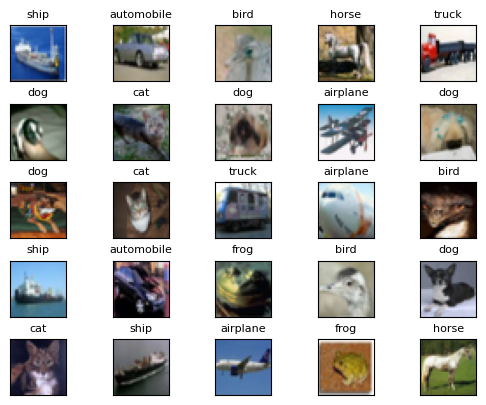

In [16]:
# plot 25 random images from the training images with thier labels
plot_sample_images(x_train, y_train)

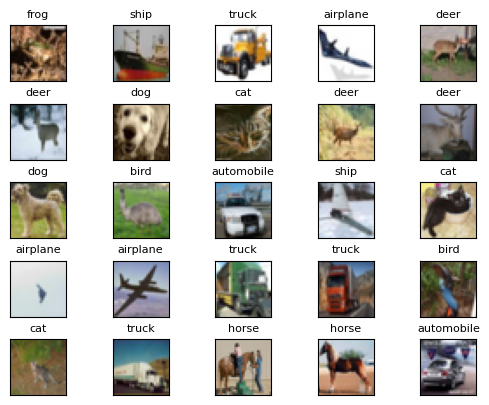

In [17]:
# plot 25 random images from the testing images with thier labels
plot_sample_images(x_test, y_test)

Text(0.5, 1.0, 'class distribution in training data')

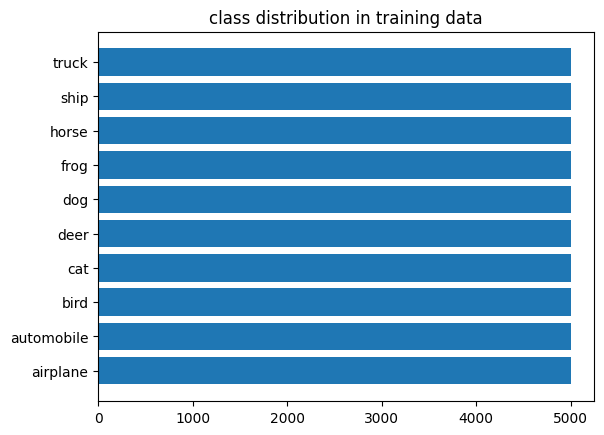

In [18]:
# plot the distribution of each class in the training data
classes, counts = np.unique(y_train, return_counts=True)
plt.barh(labels, counts)
plt.title('class distribution in training data')

Text(0.5, 1.0, 'Class distribution in testing data')

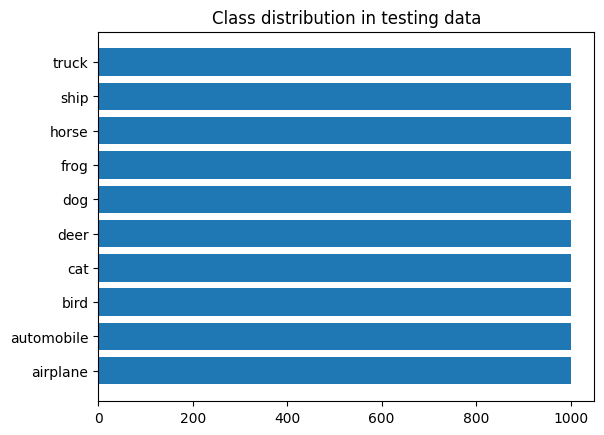

In [19]:
# plot the distribution of each class in the testing data
classes, counts = np.unique(y_test, return_counts=True)
plt.barh(labels, counts)
plt.title('Class distribution in testing data')

# Data preprocessing

In [20]:
# transform target variable into one-hotencoding
categorical_y_train = to_categorical(y_train, 10)
categorical_y_test = to_categorical(y_test, 10)

# Build the model

In [21]:
# define a sequential model
model = Sequential()

# block 1
# conv layer
model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(32, 32, 3), activation='relu', padding='same'))
# batch norm layer
model.add(BatchNormalization())
# conv layer
model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(32, 32, 3), activation='relu', padding='same'))
# batch norm layer
model.add(BatchNormalization())
# pooling layer
model.add(MaxPool2D(pool_size=(2, 2)))
# dropout layer
model.add(Dropout(0.25))

# block 2
# conv layer
model.add(Conv2D(filters=64, kernel_size=(3, 3), input_shape=(32, 32, 3), activation='relu', padding='same'))
# batch norm layer
model.add(BatchNormalization())
# conv layer
model.add(Conv2D(filters=64, kernel_size=(3, 3), input_shape=(32, 32, 3), activation='relu', padding='same'))
# batch norm layer
model.add(BatchNormalization())
# pooling layer
model.add(MaxPool2D(pool_size=(2, 2)))
# dropout layer
model.add(Dropout(0.25))

# block 3
# conv layer
model.add(Conv2D(filters=128, kernel_size=(3, 3), input_shape=(32, 32, 3), activation='relu', padding='same'))
# batch norm layer
model.add(BatchNormalization())
# conv layer
model.add(Conv2D(filters=128, kernel_size=(3, 3), input_shape=(32, 32, 3), activation='relu', padding='same'))
# batch norm layer
model.add(BatchNormalization())
# pooling layer
model.add(MaxPool2D(pool_size=(2, 2)))
# dropout layer
model.add(Dropout(0.25))

# flatten the input for the mlp
model.add(Flatten())
# first FC layer
model.add(Dense(128, activation='relu'))
# dropout layer
model.add(Dropout(0.25))
# second FC layer
model.add(Dense(64, activation='relu'))
# dropout layer
model.add(Dropout(0.25))
# output layer
model.add(Dense(10, activation='softmax'))

In [22]:
# define the metrics
METRICS = ['accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

In [23]:
# compile the model
# with categorical crossentropy loss, Adam optimizer and the defined metrics
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=METRICS)

In [24]:
# print the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 32, 32, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Bat  (None, 32, 32, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                        

In [25]:
# data Augmentation
data_generator = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
train_generator = data_generator.flow(x_train, categorical_y_train, 32)
steps_per_epoch = x_train.shape[0] // 32

In [ ]:
# fit the model
his = model.fit(train_generator,
              epochs=50,
              steps_per_epoch=steps_per_epoch,
              validation_data=(x_test, categorical_y_test),
              batch_size=32,
             )

Epoch 1/50
1562/1562 [==============================] - 50s 25ms/step - loss: 1.7459 - accuracy: 0.3631 - precision: 0.5871 - recall: 0.1504 - val_loss: 1.9530 - val_accuracy: 0.3608 - val_precision: 0.5754 - val_recall: 0.2247
Epoch 2/50
1562/1562 [==============================] - 39s 25ms/step - loss: 1.3363 - accuracy: 0.5268 - precision: 0.7158 - recall: 0.3345 - val_loss: 1.0619 - val_accuracy: 0.6284 - val_precision: 0.7752 - val_recall: 0.4801
Epoch 3/50
1562/1562 [==============================] - 42s 27ms/step - loss: 1.1372 - accuracy: 0.6043 - precision: 0.7656 - recall: 0.4455 - val_loss: 0.9837 - val_accuracy: 0.6675 - val_precision: 0.8089 - val_recall: 0.5368
Epoch 4/50
1562/1562 [==============================] - 39s 25ms/step - loss: 1.0138 - accuracy: 0.6547 - precision: 0.7931 - recall: 0.5157 - val_loss: 0.9255 - val_accuracy: 0.6826 - val_precision: 0.8166 - val_recall: 0.5570
Epoch 5/50
1562/1562 [==============================] - 38s 24ms/step - loss: 0.9433 - a

# Model Evaluation

In [ ]:
# evaluation
plt.figure(figsize=(8, 12))

plt.subplot(4, 2, 1)
plt.plot(his.history['loss'], label='Loss')
plt.plot(his.history['val_loss'], label='val_Loss')
plt.title('Loss Function Evolution')
plt.legend()

plt.subplot(4, 2, 2)
plt.plot(his.history['accuracy'], label='accuracy')
plt.plot(his.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy Function Evolution')
plt.legend()

plt.subplot(4, 2, 3)
plt.plot(his.history['precision'], label='precision')
plt.plot(his.history['val_precision'], label='val_precision')
plt.title('Precision Function Evolution')
plt.legend()

plt.subplot(4, 2, 4)
plt.plot(his.history['recall'], label='recall')
plt.plot(his.history['val_recall'], label='val_recall')
plt.title('Recall Function Evolution')
plt.legend()

In [ ]:
# calculate and print test accuracy
evaluation = model.evaluate(x_test, categorical_y_test)
print(f'Test Accuracy : {evaluation[1] * 100:.2f}%')

In [ ]:
# get predictions
y_pred = model.predict(x_test)
# get the predicted class
y_pred = np.argmax(y_pred, axis=1)
# find the confusion matrix
cm = confusion_matrix(y_test, y_pred)
# display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=labels)

fig, ax = plt.subplots(figsize=(10, 10))
disp = disp.plot(xticks_rotation='vertical', ax=ax,cmap='summer')

plt.show()

In [ ]:
print('                      classification_report                      ')
print(classification_report(y_test, y_pred))

# Test the model

In [ ]:
plt.figure(figsize=(2, 2))
plt.axis('off')
# get an image from the test images
test_image = x_test[1000]
# show the image
plt.imshow(test_image)
# predict the class of the image
pred_class = np.argmax(model.predict(test_image.reshape(1, 32, 32, 3)))
# print the actual class of the image
print(f" the actual class of the image is : {labels[y_test[1000]]}")
# print the predicted class of the image
print(f"the predicted class by the model is : {labels[pred_class]}")

# Save the model

In [ ]:
from tensorflow.keras.models import load_model

model.save('cifar10_model.h5')